In [1]:
import os

import geopandas as gpd
import pandas as pd
import numpy as np
import momepy as mm
import networkx as nx

from sqlalchemy import create_engine

import matplotlib.pyplot as plt
from mapclassify import greedy

user = os.environ.get('DB_USERNAME')
pwd = os.environ.get('DB_PASSWORD')
host = os.environ.get('DB_HOSTNAME')
port = os.environ.get('DB_PORT')

url = f"postgres+psycopg2://{user}:{pwd}@{host}:{port}/geodemo"
engine = create_engine(url)

In [2]:
from shapely.geometry import Point, MultiLineString, MultiPolygon
from shapely.ops import split

In [3]:
def pgselect(table, buffer=900, x=338157, y=393037):
    sql = f'''
    SELECT * FROM {table} 
    WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer})'''
    return gpd.read_postgis(sql, engine, geom_col='geometry')

In [4]:
def encircle(geometry, circle):
    # if geometry is polygon
    if geometry.type == 'Polygon':
        return MultiPolygon([p for p in list(split(geometry, circle.boundary)) 
                         if circle.buffer(1).contains(p)])
    if geometry.type == 'LineString':
        return MultiLineString([p for p in list(split(geometry, circle.boundary)) 
                         if circle.buffer(1).contains(p)])
    

In [5]:
rds = pgselect('openroads')
bgs = pgselect('openmaplocal')
pn = pgselect('openuprn')
rwy = pgselect('railways')
encs = pgselect('enclosures')

In [6]:
t = encs.iloc[3].geometry

In [7]:
nearest = pd.read_csv('nearest_rds.csv', index_col=False)

In [8]:
nearest

,UPRN,nearest_rd
0,38000554,id26591034-E445-4B7F-80AA-E7EEBF03F2FC
1,38000555,id26591034-E445-4B7F-80AA-E7EEBF03F2FC
2,38000556,id26591034-E445-4B7F-80AA-E7EEBF03F2FC
3,38000557,id26591034-E445-4B7F-80AA-E7EEBF03F2FC
4,38000558,id5852DA83-18B0-4700-87C4-C8539FC17265
...,...,...
3697,10025739566,id3963A194-EB75-4B90-8299-3B784ECFDDDA
3698,10091806097,idD41DDEB3-66E2-40F9-8987-943C41E57DCE
3699,10091806099,idD41DDEB3-66E2-40F9-8987-943C41E57DCE
3700,10091960195,id442F5AF9-FD44-4496-BE8F-3963FF3D2E6F


In [9]:
trds = rds.loc[rds.geometry.apply(
    lambda x: t.buffer(1).contains(x))]

In [10]:
nodes = set(trds.startNode).union(set(trds.endNode))

In [11]:
trds.columns

Index(['id', 'endNode', 'startNode', 'roadNumberTOID', 'roadNameTOID',
       'fictitious', 'roadClassification', 'roadFunction', 'formOfWay',
       'length', 'length_uom', 'loop', 'primaryRoute', 'trunkRoad',
       'roadClassificationNumber', 'name1', 'name1_lang', 'name2',
       'name2_lang', 'roadStructure', 'geometry'],
      dtype='object')

In [12]:
trds.roadFunction.unique()

array(['A Road', 'Local Road', 'Secondary Access Road',
       'Restricted Local Access Road'], dtype=object)

In [73]:
nc = nearest.groupby('nearest_rd').count()

In [80]:
nc.reset_index(inplace=True)

In [105]:
nc.columns = ['id','nearby']

In [146]:
r = trds[['id', 'startNode', 'endNode', 'roadFunction', 'length', 'name1', 'geometry']]

In [147]:
r = r.merge(nc, on='id', how='left')

In [134]:
r.nearby = r.nearby.fillna(0)

In [135]:
trds = rds.loc[rds.geometry.apply(lambda x: t.buffer(1).contains(x))]
tbgs = bgs.loc[bgs.geometry.apply(lambda x: t.contains(x))]
tpn = pn.loc[pn.geometry.apply(lambda x: t.contains(x))]

In [137]:
type(r)

geopandas.geodataframe.GeoDataFrame

In [184]:
r = r.loc[~(r.roadFunction=='Secondary Access Road')]

In [235]:
r['residential'] = r.density > 0.5

<AxesSubplot:>

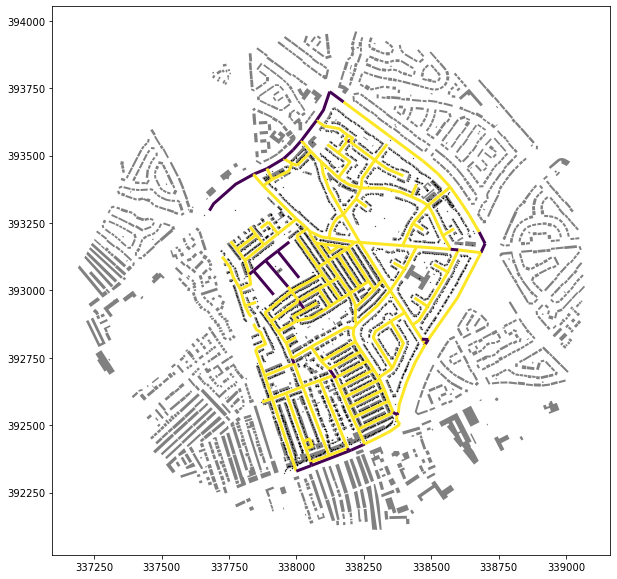

In [253]:
fig, ax = plt.subplots(figsize=(10,15))
r.plot('residential', ax=ax, linewidth=3)
bgs.plot(ax=ax,color='gray')
tpn.plot(ax=ax,markersize=0.1, color='k')

In [209]:
r_ = r.copy()

In [212]:
r_['density'].fillna(0, inplace=True)

In [213]:
r_.density

0       29.750000
1       64.000000
2      108.000000
3        0.000000
4        0.000000
          ...    
240      0.852941
241      5.333333
242      2.208333
243      0.000000
244      0.000000
Name: density, Length: 233, dtype: float64

In [254]:
r_[['name1','id','density','geometry']].sort_values('density', ascending=False)

,name1,id,density,geometry
2,Townsend Lane,idCF1BDD76-9D33-4BFE-B66B-619ADA602C02,108.00,"LINESTRING (337677.540 393295.970, 337692.970 ..."
122,None,idDF1DD781-E1FB-43D8-BB95-55574A148678,64.50,"LINESTRING (337885.370 393110.990, 337919.990 ..."
1,Queens Drive West Derby,id368C3678-9B72-4E4B-A7B2-6E27ADCBFBA4,64.00,"LINESTRING (338123.490 393737.050, 338149.370 ..."
0,Townsend Avenue,id05F0439A-C864-4EC4-9E9F-4C4434C5097B,29.75,"LINESTRING (338074.010 393629.490, 338100.500 ..."
237,West Derby Road,id94C6E0C5-53D7-4668-80A6-DA3EE4389EF0,29.50,"LINESTRING (337999.600 392329.330, 338027.310 ..."
...,...,...,...,...
202,Delamain Road,id38BC90AA-0851-4437-9768-37A2908F99F5,0.00,"LINESTRING (338489.200 392817.640, 338477.140 ..."
203,Muirhead Avenue,idD605EDDC-3D6C-4C9E-B4CE-2AA0124E8A8B,0.00,"LINESTRING (338478.510 392800.460, 338483.860 ..."
204,West Derby Road,idEFB5E9D4-2B62-4A5B-8B94-A612AF5608C3,0.00,"LINESTRING (338056.640 392350.760, 338125.320 ..."
207,Osborne Road,id65891BFA-1171-4EFE-BA7A-C810F2897BD4,0.00,"LINESTRING (338194.000 392403.810, 338192.000 ..."


In [220]:
r.nearby.fillna(0,inplace=True)

In [224]:
r['density'] = r['nearby']/r['length'] * 10

In [250]:
r.density.describe()

count    233.000000
mean       1.933099
std        1.443842
min        0.000000
25%        1.111111
50%        1.818182
75%        2.637363
max       11.724138
Name: density, dtype: float64

In [ ]:
r.density.describe().std

In [ ]:
r.density.describe().std

<AxesSubplot:>

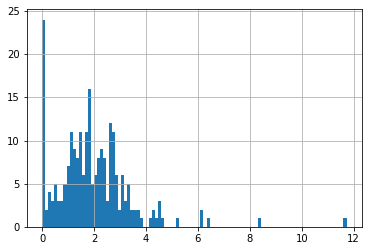

In [237]:
r.density.hist(bins=100)

In [198]:
r.roadFunction.unique()

array(['A Road', 'Local Road', 'Restricted Local Access Road'],
      dtype=object)